# IEKF class example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
sys.path.insert(0,'../')

In [2]:

import sympy as sp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import trange

from system_identification.iekf import IteratedExtendedKalmanFilter

## Define filter

In [3]:
x1, x2, u1 = sp.symbols("x1 x2 u1")
iekf = IteratedExtendedKalmanFilter(
    x=[x1, x2],
    z=['z1'],
    u=[u1],
    f=sp.Matrix([
        x2*sp.cos(x1)**3 + u1,
        x2 * u1 - x2
    ]),
    h=sp.Matrix([
        x1**2 + x2**2 * u1
    ]),
    g=sp.Matrix(np.eye(2)),
    max_iterations=100,
    eps=1e-10,
)
iekf

$$x = \left( x_{1}, \  x_{2}\right)$$  
$$z = \left( \mathtt{\text{z1}},\right)$$  
$$u = \left( u_{1},\right)$$  
$$f(\dots) = \left[\begin{matrix}u_{1} + x_{2} \cos^{3}{\left(x_{1} \right)}\\u_{1} x_{2} - x_{2}\end{matrix}\right]$$  
$$g(\dots) = \left[\begin{matrix}1.0 & 0\\0 & 1.0\end{matrix}\right]$$  
$$h(\dots) = \left[\begin{matrix}u_{1} x_{2}^{2} + x_{1}^{2}\end{matrix}\right]$$  
$$F_x(\dots) = \left[\begin{matrix}- 3 x_{2} \sin{\left(x_{1} \right)} \cos^{2}{\left(x_{1} \right)} & \cos^{3}{\left(x_{1} \right)}\\0 & u_{1} - 1\end{matrix}\right]$$  
$$H_x(\dots) = \left[\begin{matrix}2 x_{1} & 2 u_{1} x_{2}\end{matrix}\right]$$

## Create test data

In [4]:
# Create input signal.
t = np.arange(0, 10, 0.01)
u1_values = 3 * np.sin(2*np.pi*t) + np.cos(11*np.pi*t) + 0.4 * np.tanh((t - 2.4) * 10) - 0.6 * np.tanh((t - 5.3) * 10)


u = xr.Dataset(
    data_vars={
        "u1": (('t',), u1_values)
    },
    coords={"t": t}
)

# Generate test data by simulating dynamics
np.random.seed(0)
data = iekf.sim(
    x_0=[2, -3],
    u=u,
    system_noise=[1., 1.],
    system_bias=[0., 0.],
    measurement_noise=[1.],
    measurement_bias=[0.],
)
data

<xarray.Dataset>
Dimensions:  (t: 1000)
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 9.95 9.96 9.97 9.98 9.99
Data variables:
    u1       (t) float64 1.2 1.329 1.347 1.271 ... -0.7587 -0.2531 0.1945 0.5525
    x1       (t) float64 2.0 2.024 2.049 2.067 2.087 ... 4.52 4.514 4.497 4.503
    x2       (t) float64 -3.0 -2.984 -2.995 -2.991 ... -0.1086 -0.1015 -0.1057
    z1       (t) float64 16.56 17.8 16.17 16.4 16.02 ... 22.37 20.48 20.29 22.06

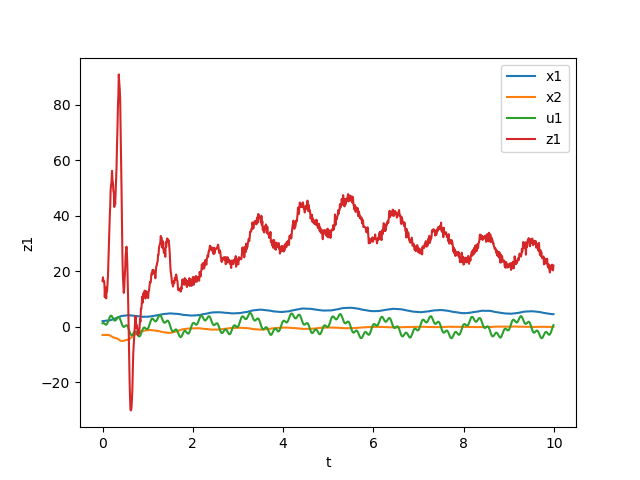

In [5]:
plt.figure()
data.x1.plot.line(label="x1")
data.x2.plot.line(label="x2")
data.u1.plot.line(label="u1")
data.z1.plot.line(label="z1")
plt.legend()

## Run filter and smoother

In [6]:
n=9
iekf=iekf
data=data
x_0=[2., -3]
p_0=np.diag([10., 10.])
q=np.eye(2)
r=[[1.]]

s_data = iekf.smooth(
    data=data,
    x_0=x_0,
    p_0=p_0,
    q=q,
    r=r,
    verbose=True
)

  0%|          | 0/999 [00:00<?, ?it/s, Filtering]

  0%|          | 0/999 [00:00<?, ?it/s, Smoothing]

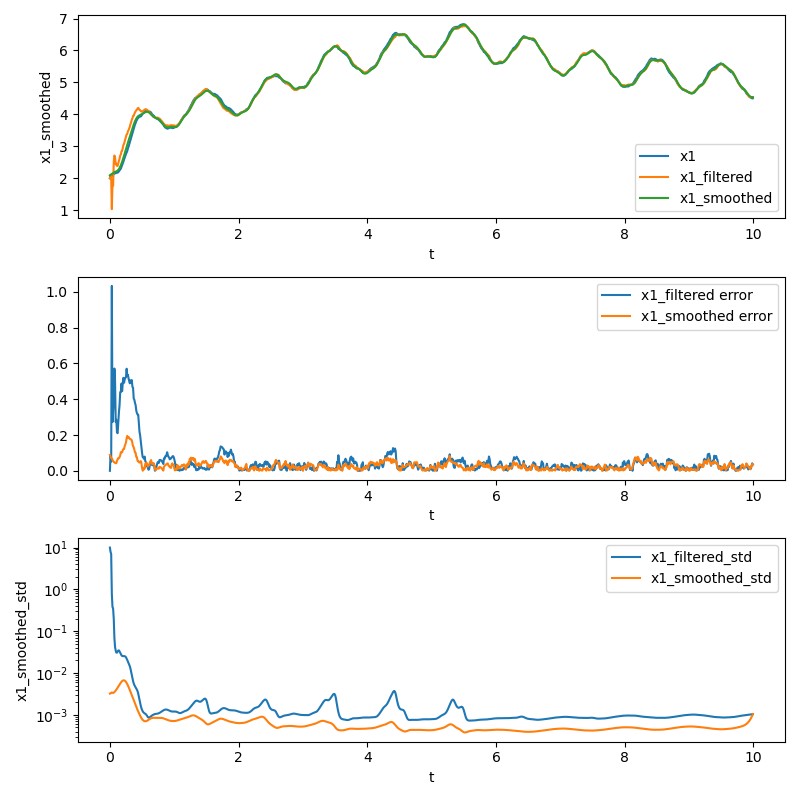

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 8))
s_data.x1.plot.line(label="x1", ax=ax1)
s_data.x1_filtered.plot.line(label="x1_filtered", ax=ax1)
s_data.x1_smoothed.plot.line(label="x1_smoothed", ax=ax1)
ax1.legend()

abs(s_data.x1 - s_data.x1_filtered).plot.line(label="x1_filtered error", ax=ax2)
abs(s_data.x1 - s_data.x1_smoothed).plot.line(label="x1_smoothed error", ax=ax2)
ax2.legend()

s_data.x1_filtered_std.plot.line(label="x1_filtered_std", ax=ax3)
s_data.x1_smoothed_std.plot.line(label="x1_smoothed_std", ax=ax3)
ax3.set_yscale("log")
ax3.legend()
plt.tight_layout()